In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# Path to the directory containing pickle files
dir_path = '/storage/vbutoi/scratch/ESE/records/WMH_aug_runs'

# List all pickle files in the directory
pickle_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

# Initialize an empty DataFrame
all_logs = pd.DataFrame()

# Iterate through each pickle file and append its contents to the DataFrame
for p_file in pickle_files:
    file_path = os.path.join(dir_path, p_file)
    temp_df = pd.read_pickle(file_path)
    all_logs = pd.concat([all_logs, temp_df], ignore_index=True)

In [3]:
all_logs

,accuracy,bin_weighting,cal_metric,cal_score,class_type,data_idx,dice,gt_lab_amount,lab_w_accuracy,num_bins,pred_lab_amount,slice_idx,split,task,dataset
0,1.0,proportional,ACE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore,NaN
1,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore,NaN
2,1.0,proportional,ReCE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore,NaN
3,1.0,proportional,ACE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,1,train,Singapore,NaN
4,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,1,train,Singapore,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84475,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,254,train,Singapore,ese.experiment.datasets.WMH
84476,1.0,proportional,ReCE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,254,train,Singapore,ese.experiment.datasets.WMH
84477,1.0,proportional,ACE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,255,train,Singapore,ese.experiment.datasets.WMH
84478,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,255,train,Singapore,ese.experiment.datasets.WMH


## Look at the particular comparison we want to make.

In [4]:
# Isolate the cases which have no-label and cases where there is at least some label.
def has_label(value):
    return (value != 0.0)

# Add some new useful columns
all_logs['has_label'] = all_logs['gt_lab_amount'].apply(has_label) 

def reorder_splits(df):
    train_logs = df[df['split'] == 'train']
    val_logs = df[df['split'] == 'val']
    cal_logs = df[df['split'] == 'cal']
    fixed_df = pd.concat([train_logs, val_logs, cal_logs])
    return fixed_df

# Set the rows so that it's train, val, cal
all_logs = reorder_splits(all_logs)

# Now we want to collapse the data by subject, so we can get the mean metric score for each subject.
logs_per_subject = all_logs.groupby(['data_idx', 'cal_metric', 'bin_weighting', 'task', 'split']).agg({
    'pred_lab_amount': 'mean',
    'gt_lab_amount': 'mean',
    'cal_score': 'mean',
    'accuracy': 'mean',
    'dice': 'mean',
    'lab_w_accuracy': 'mean'
}).reset_index()

logs_per_subject = reorder_splits(logs_per_subject)

# Group the metrics by important factors
grouped_logs = all_logs.groupby(['task', 'cal_metric', 'split'])
grouped_logs_per_subject = logs_per_subject.groupby(['task', 'cal_metric', 'split'])

In [5]:
logs_per_subject

,data_idx,cal_metric,bin_weighting,task,split,pred_lab_amount,gt_lab_amount,cal_score,accuracy,dice,lab_w_accuracy
1,0,ACE,proportional,Amsterdam,train,9.367188,7.746094,0.008244,0.999841,0.743614,0.912939
4,0,ACE,proportional,Singapore,train,155.691406,314.496094,0.041486,0.997388,0.820527,0.907223
7,0,ECE,proportional,Amsterdam,train,9.367188,7.746094,0.008311,0.999841,0.743614,0.912939
10,0,ECE,proportional,Singapore,train,155.691406,314.496094,0.041558,0.997388,0.820527,0.907223
13,0,ReCE,proportional,Amsterdam,train,9.367188,7.746094,0.061071,0.999841,0.743614,0.912939
...,...,...,...,...,...,...,...,...,...,...,...
95,5,ECE,proportional,Amsterdam,cal,178.589844,223.277344,0.015408,0.998560,0.735461,0.941460
100,5,ReCE,proportional,Amsterdam,cal,178.589844,223.277344,0.065397,0.998560,0.735461,0.941460
105,6,ACE,proportional,Amsterdam,cal,15.175781,13.371094,0.008703,0.999743,0.673523,0.926637
110,6,ECE,proportional,Amsterdam,cal,15.175781,13.371094,0.008945,0.999743,0.673523,0.926637


## ECE vs ReCE

In [6]:
from scipy.stats import pearsonr

# Define the custom function to calculate and annotate correlation
def annotate_correlation(data, **kws):
    x, y = data['ECE'], data['ReCE']
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.text(.1, .9, f'r = {r:.2f}', transform=ax.transAxes)

In [7]:
# plt.rcParams.update({'font.size': 20})  
# # POplt.rcParams.update({'font.size': 20})  vot the DataFrame
# pivot_df = logs_per_subject.pivot(index=['data_idx', 'task', 'split', 'gt_lab_amount'], columns='cal_metric', values='cal_score').reset_index()
# sorted_pivot_df = reorder_splits(pivot_df)

# # Now plot the scatter plot with each task as a different column
# g = sns.relplot(data=sorted_pivot_df, 
#             x='ECE', 
#             y='ReCE', 
#             col='split', 
#             row='task',
#             hue='gt_lab_amount',
#             height=8,
#             s=100)

# # Map the custom function onto the FacetGrid
# g.map_dataframe(annotate_correlation)

## Correlation Comparison: Accuracy

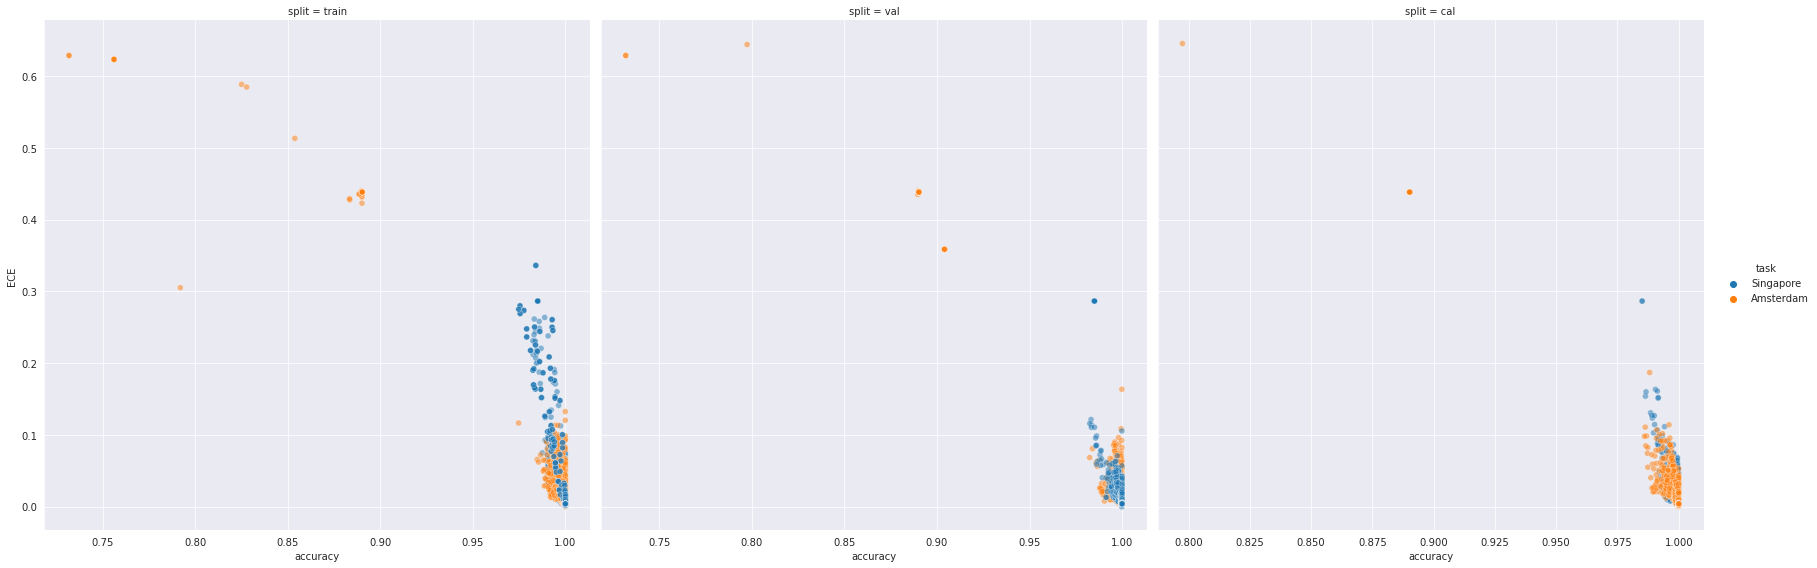

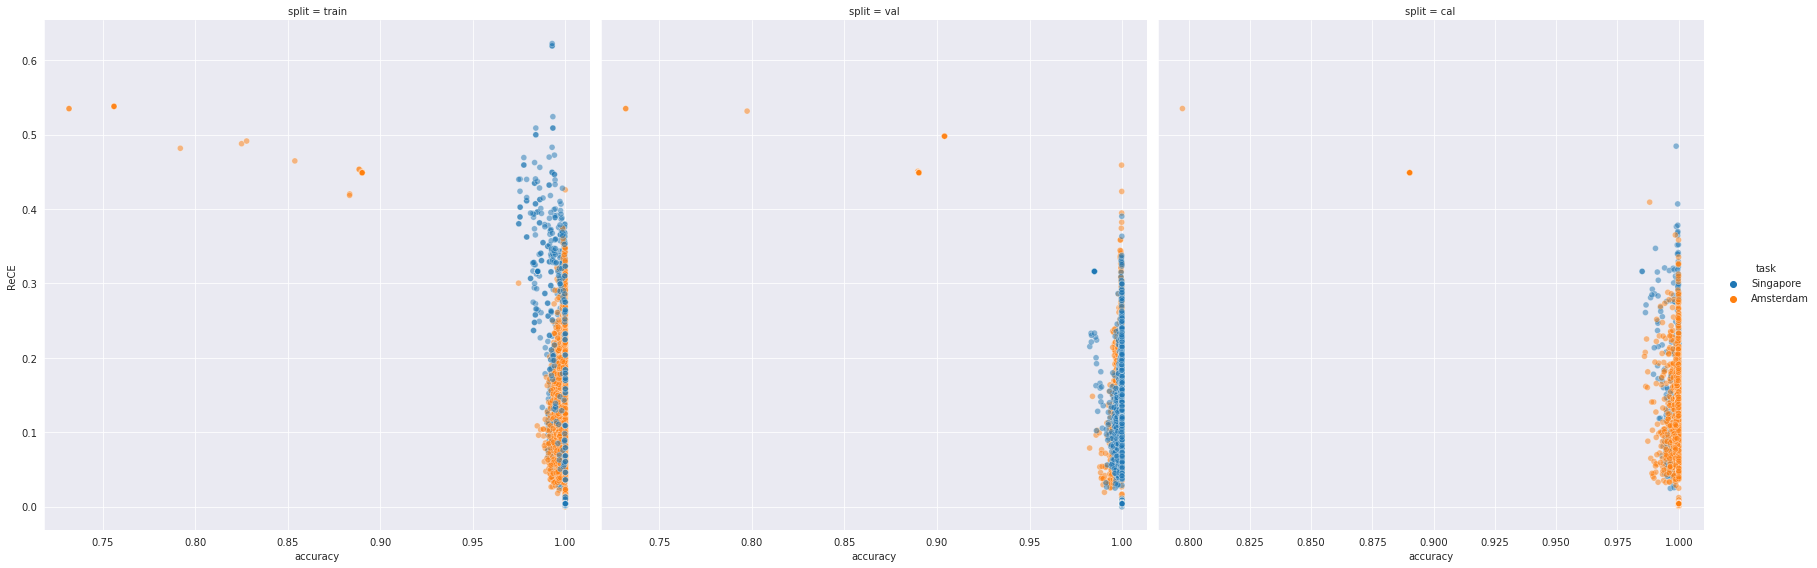

In [8]:
plt.rcParams.update({'font.size': 20})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=all_logs[all_logs['cal_metric'] == metric],
        x='accuracy',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

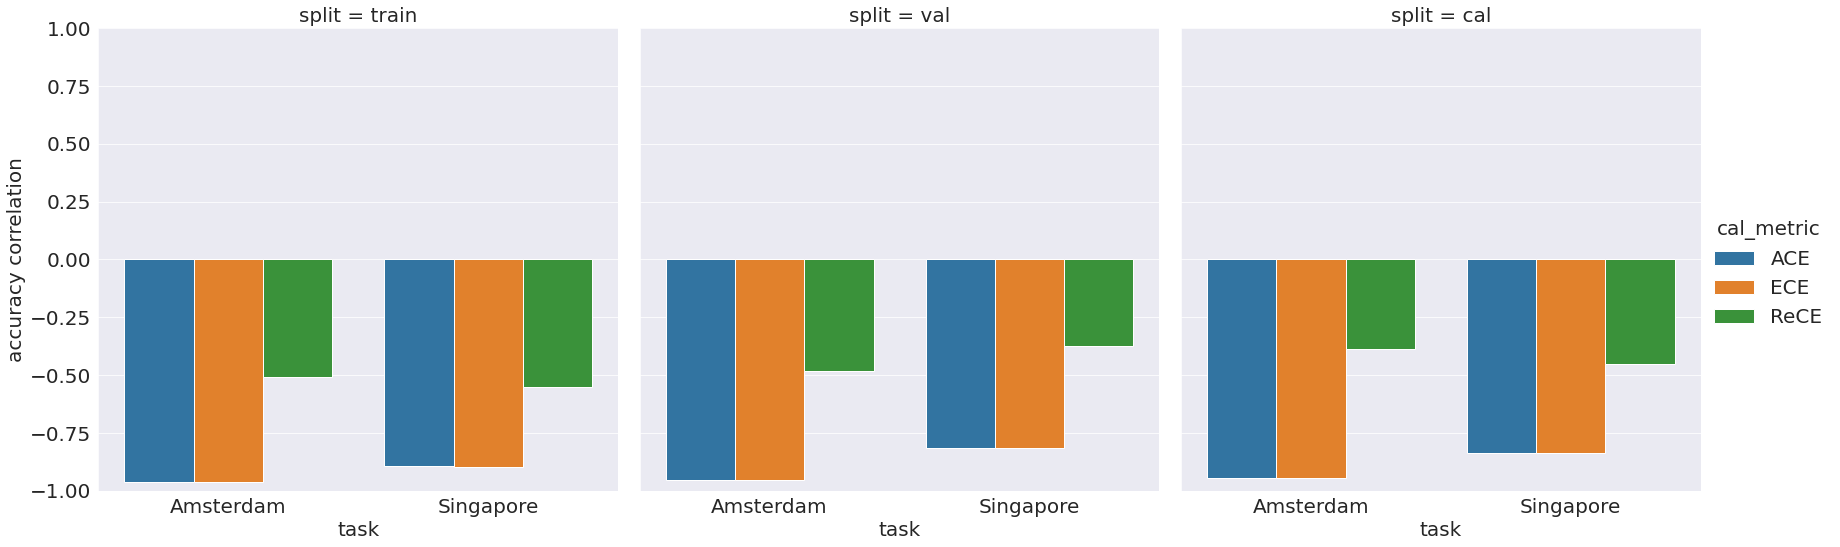

In [9]:
plt.rcParams.update({'font.size': 20})  

acc_corr = grouped_logs.apply(lambda x: x['accuracy'].corr(x['cal_score'])).reset_index(name='accuracy correlation')
acc_corr = reorder_splits(acc_corr)
g = sns.catplot(data=acc_corr, 
                x="task", 
                y="accuracy correlation", 
                hue='cal_metric', 
                col="split", 
                kind="bar", 
                height=8, 
                aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

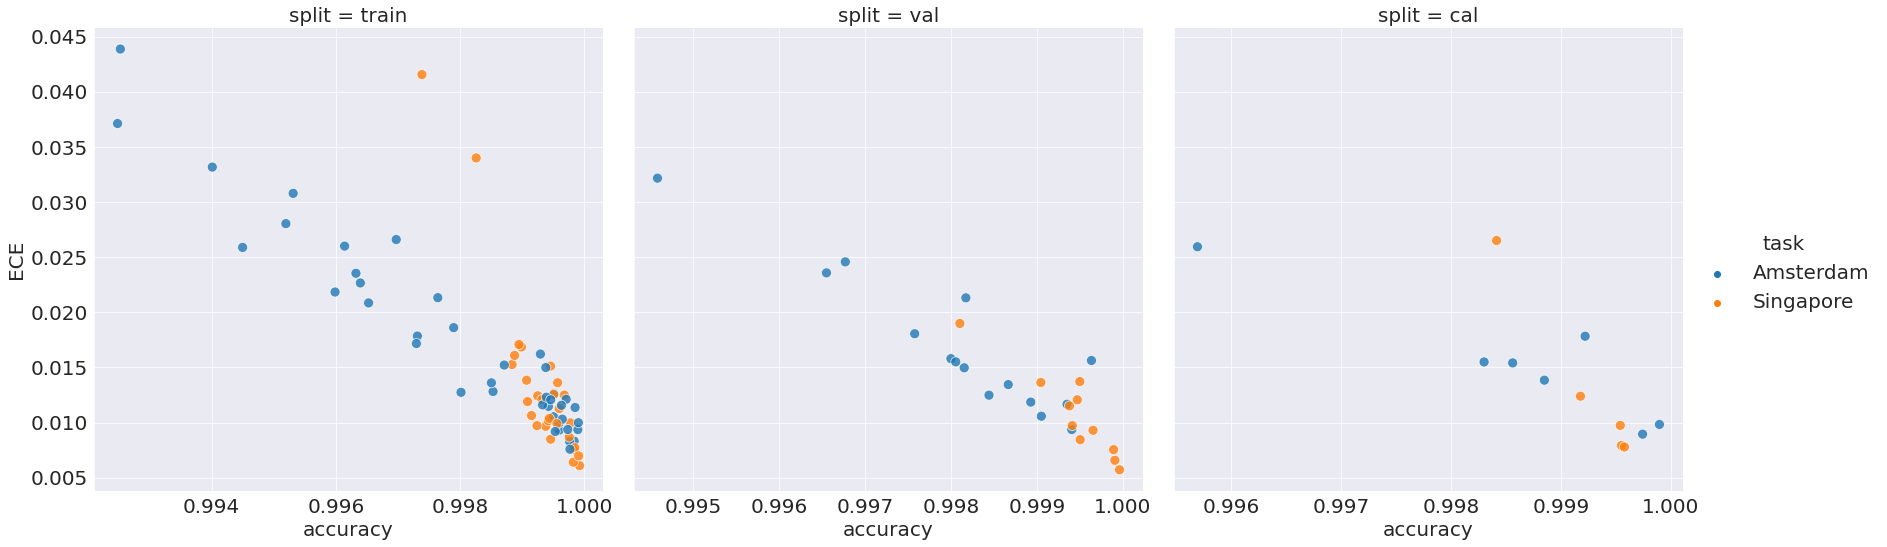

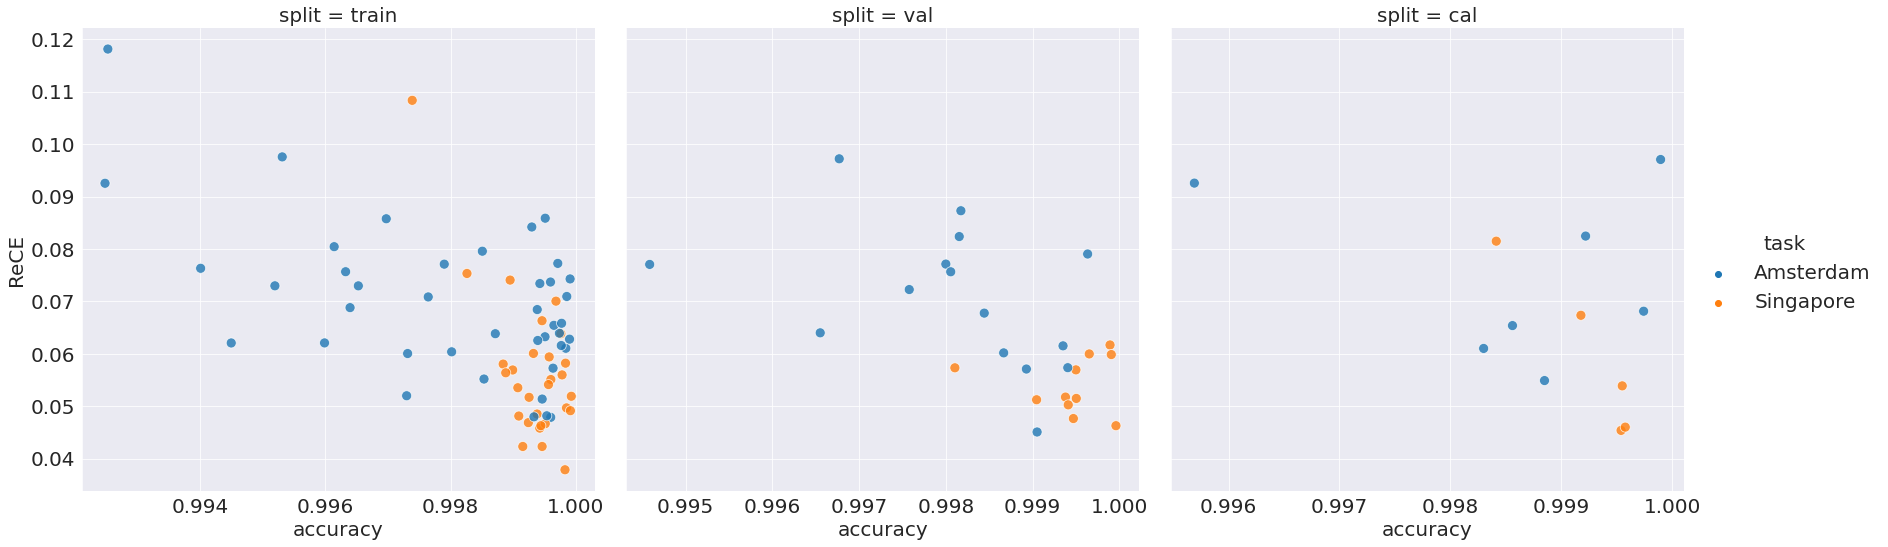

In [10]:
plt.rcParams.update({'font.size': 20})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['cal_metric'] == metric],
        x='accuracy',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

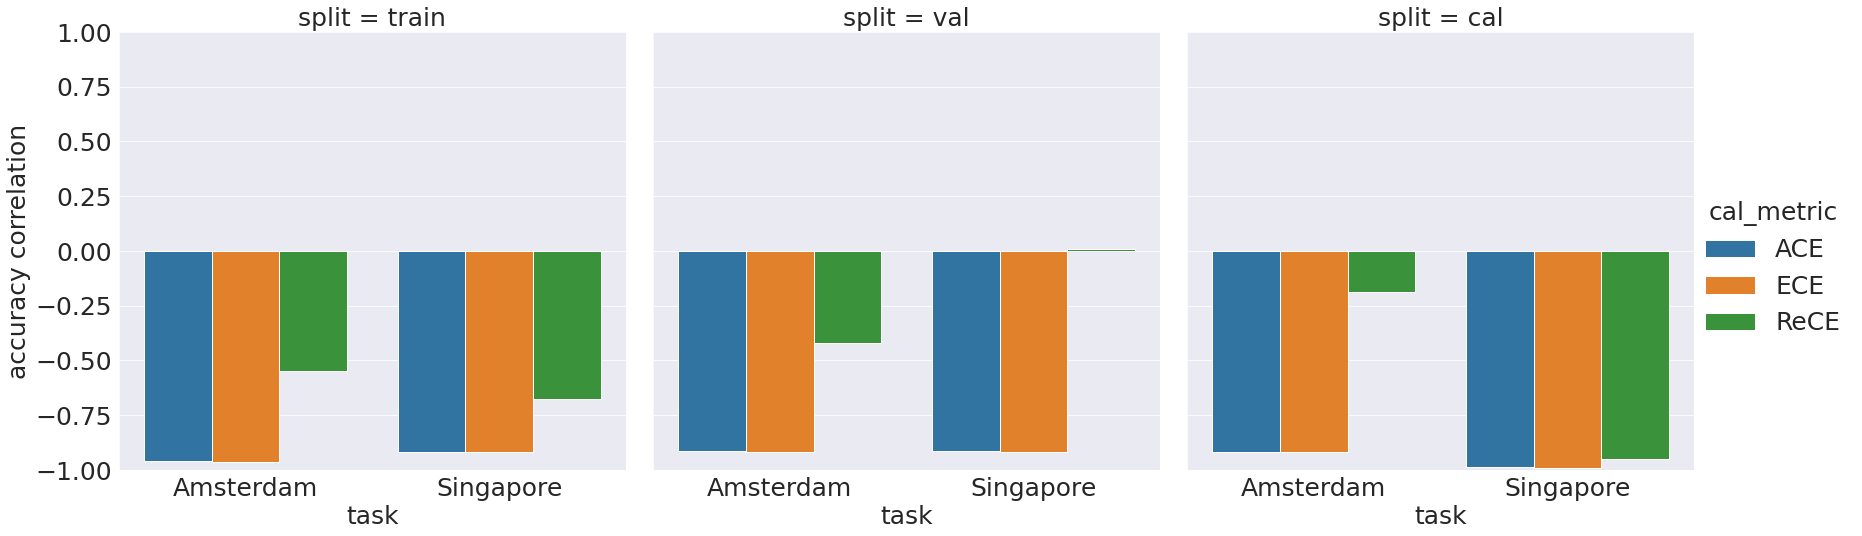

In [11]:
plt.rcParams.update({'font.size': 25})  

# Group by the three columns and apply correlation
acc_subj_correlations = grouped_logs_per_subject.apply(lambda x: x['accuracy'].corr(x['cal_score'])).reset_index(name='accuracy correlation')
acc_subj_correlations = reorder_splits(acc_subj_correlations)
g = sns.catplot(data=acc_subj_correlations, 
                x="task", 
                y="accuracy correlation", 
                hue='cal_metric', 
                col="split", 
                kind="bar", 
                height=8, 
                aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

## Correlation Comparison: Dice Score

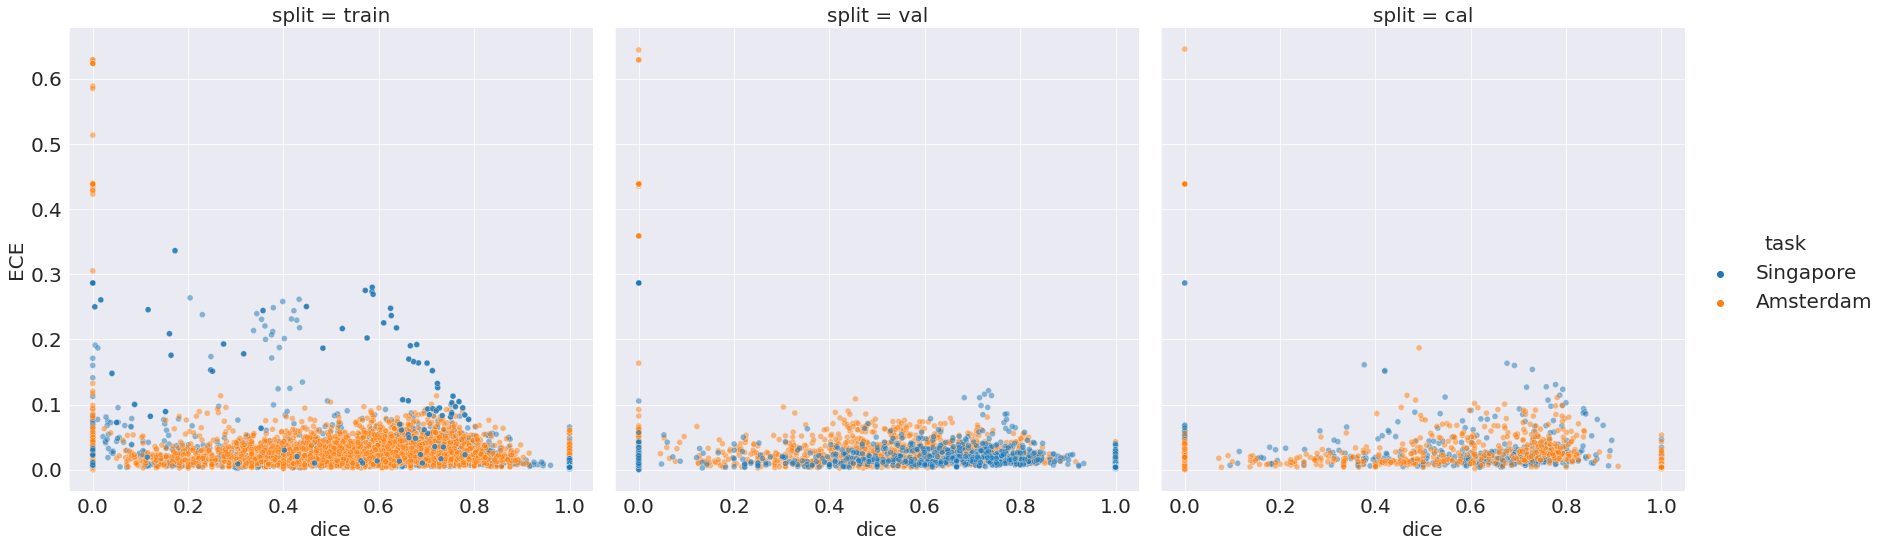

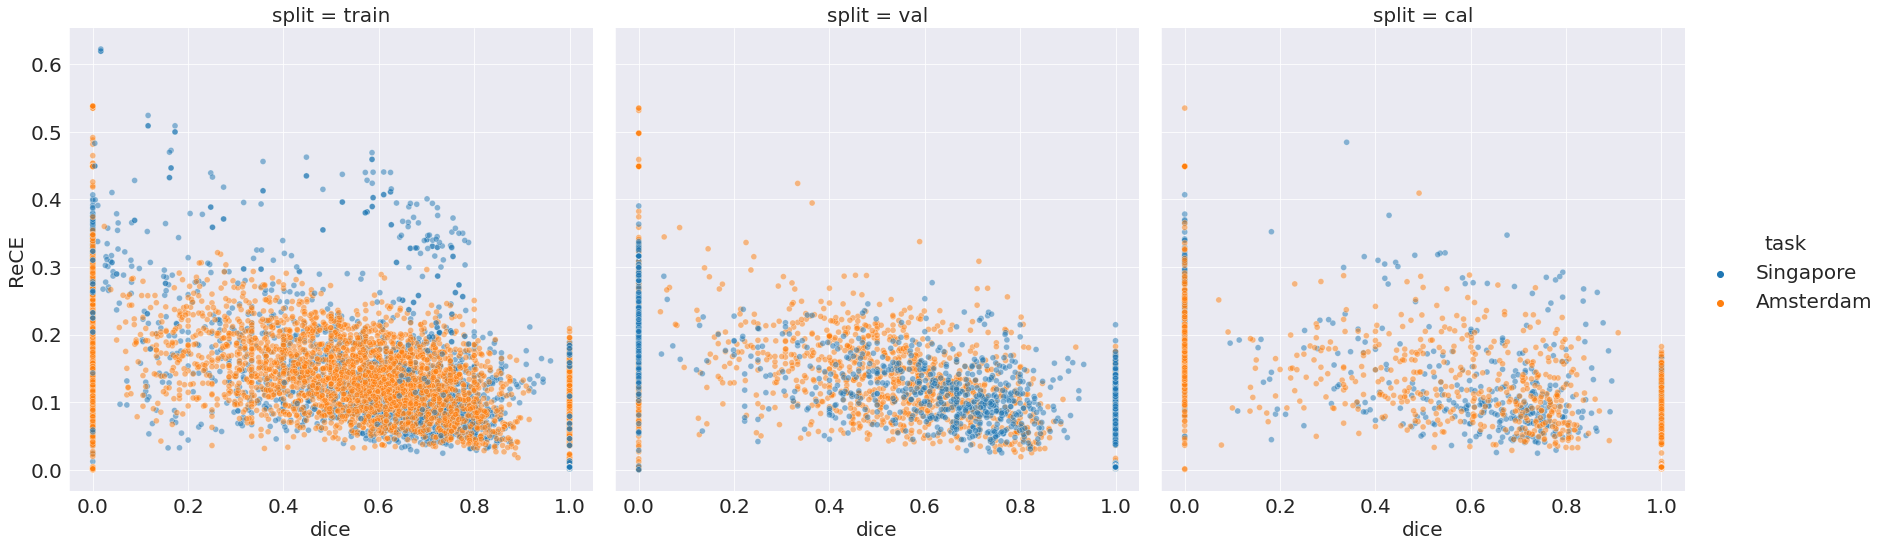

In [12]:
plt.rcParams.update({'font.size': 20})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=all_logs[all_logs['cal_metric'] == metric],
        x='dice',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

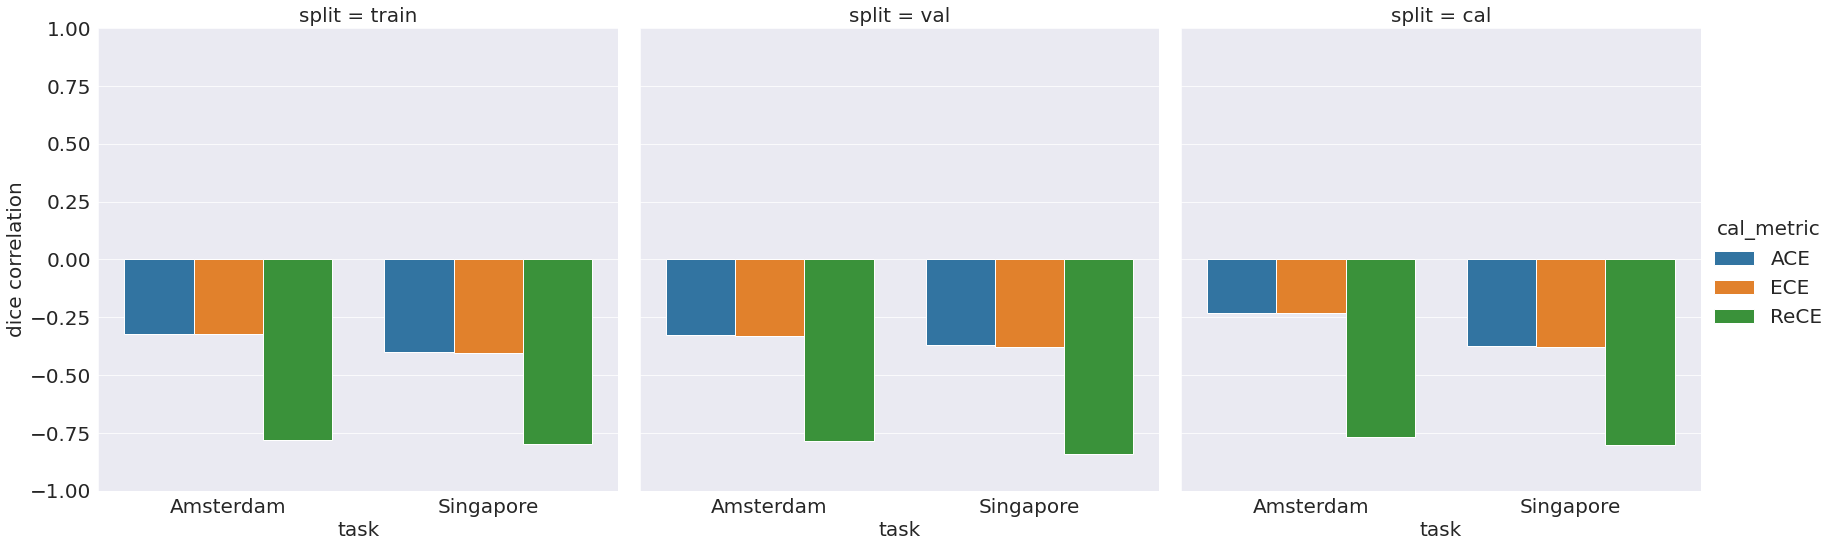

In [13]:
plt.rcParams.update({'font.size': 20})  

dice_correlations = grouped_logs.apply(lambda x: x['dice'].corr(x['cal_score'])).reset_index(name='dice correlation')
dice_correlations = reorder_splits(dice_correlations)
g = sns.catplot(data=dice_correlations, 
                x="task", 
                y="dice correlation", 
                hue='cal_metric', 
                col="split", 
                kind="bar", 
                height=8, 
                aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

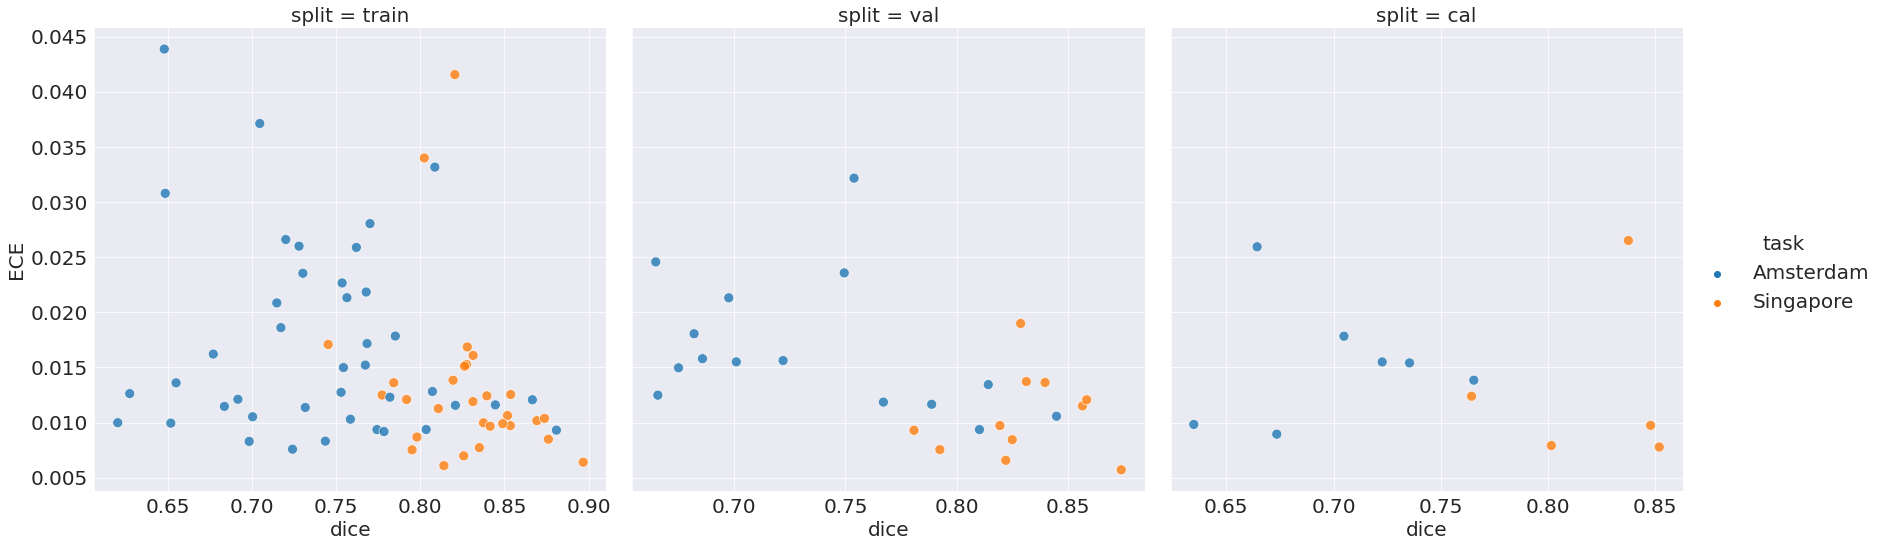

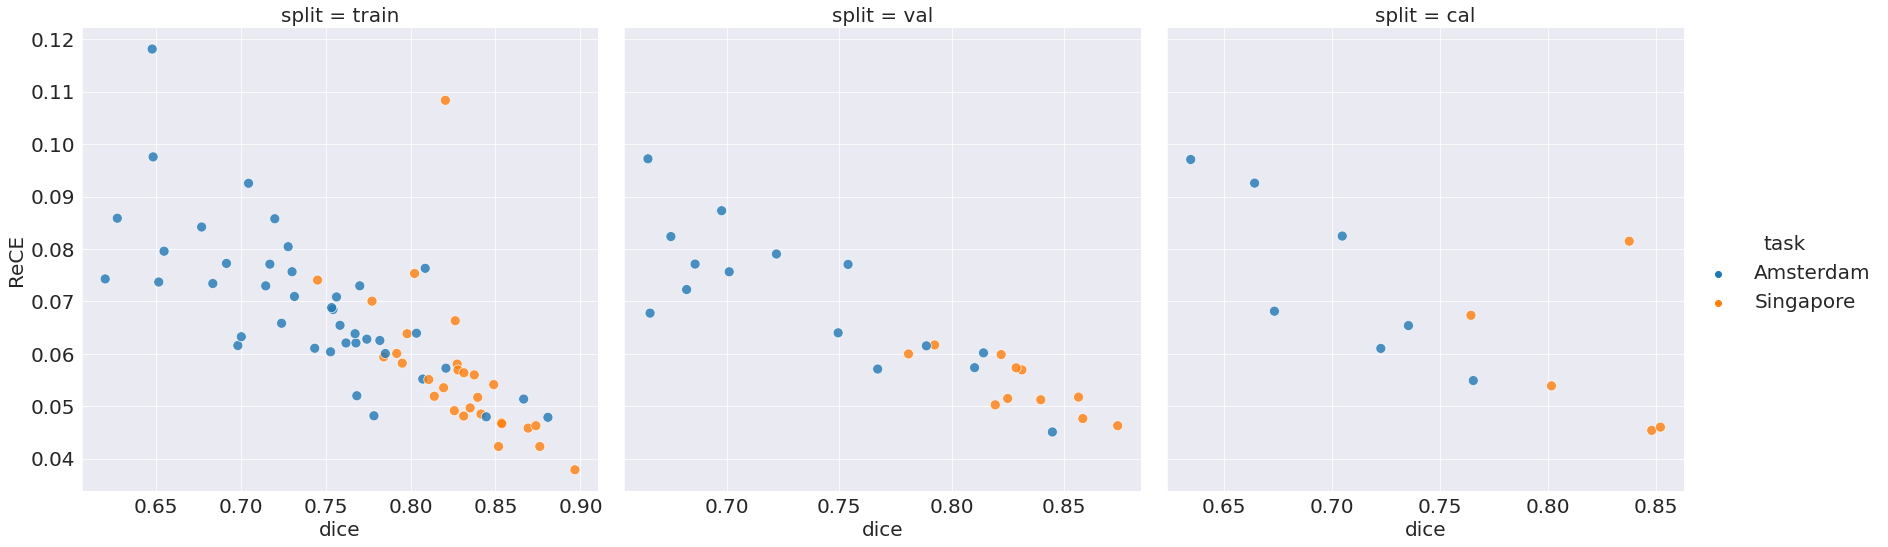

In [14]:
plt.rcParams.update({'font.size': 20})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['cal_metric'] == metric],
        x='dice',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

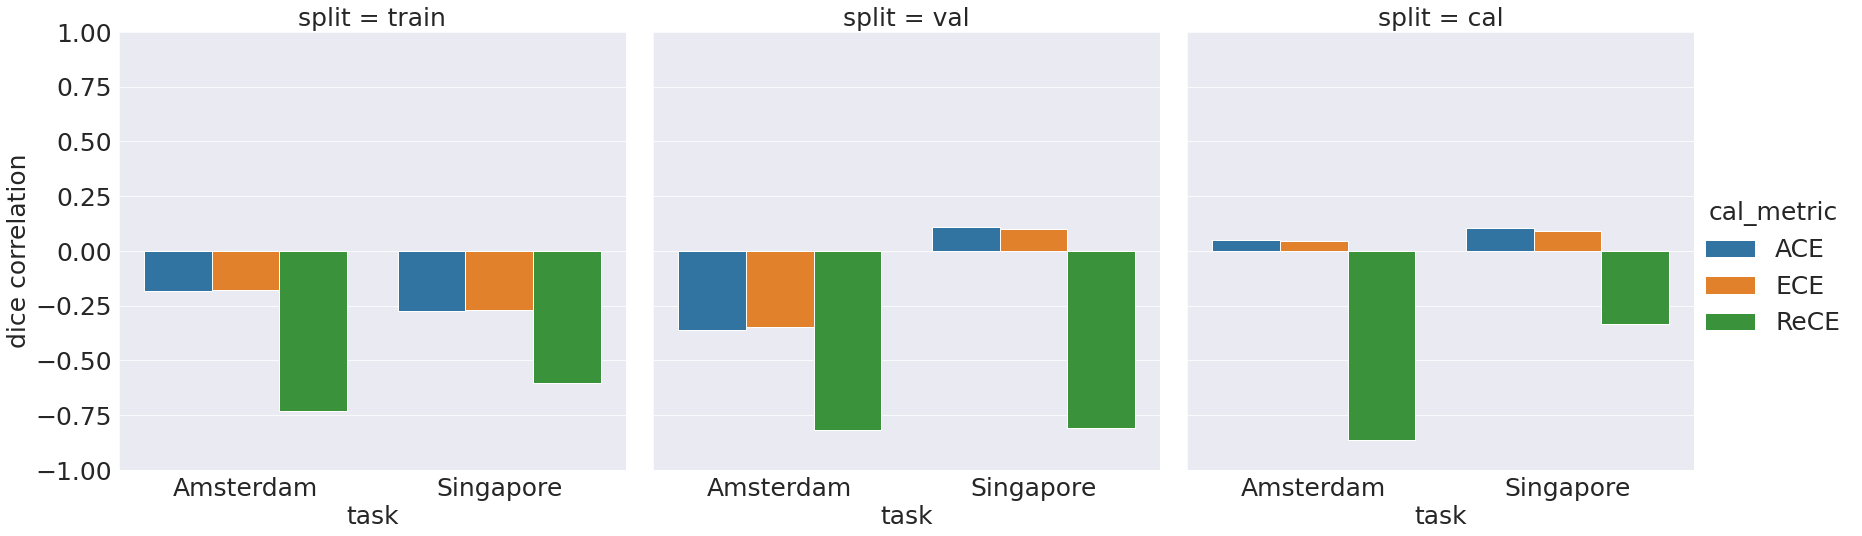

In [15]:

plt.rcParams.update({'font.size': 25})  

# Group by the three columns and apply correlation
dice_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['dice'].corr(x['cal_score'])).reset_index(name='dice correlation')
dice_subject_correlations = reorder_splits(dice_subject_correlations)
g = sns.catplot(data=dice_subject_correlations, 
                x="task", 
                y="dice correlation", 
                hue='cal_metric', 
                col="split", 
                kind="bar", 
                height=8, 
                aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

## Correlation Comparison: Groundtruth Label Amount

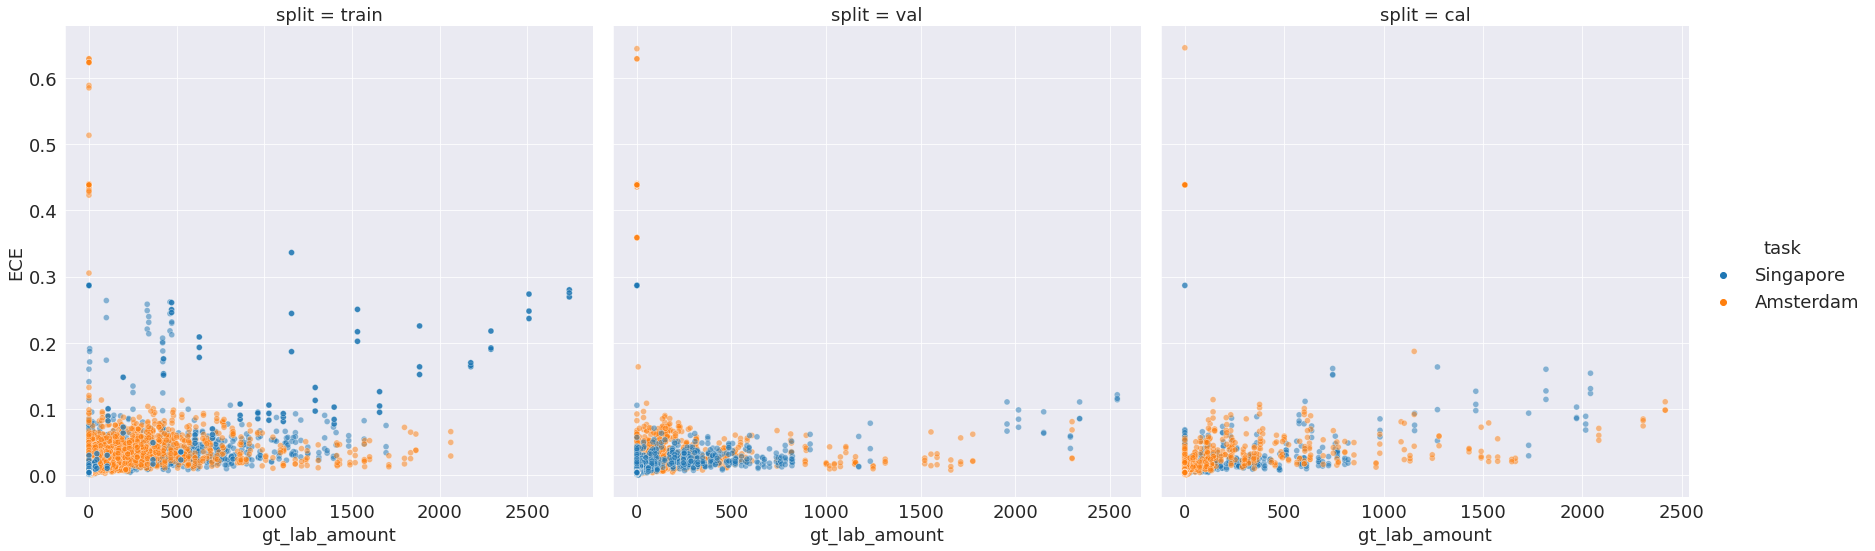

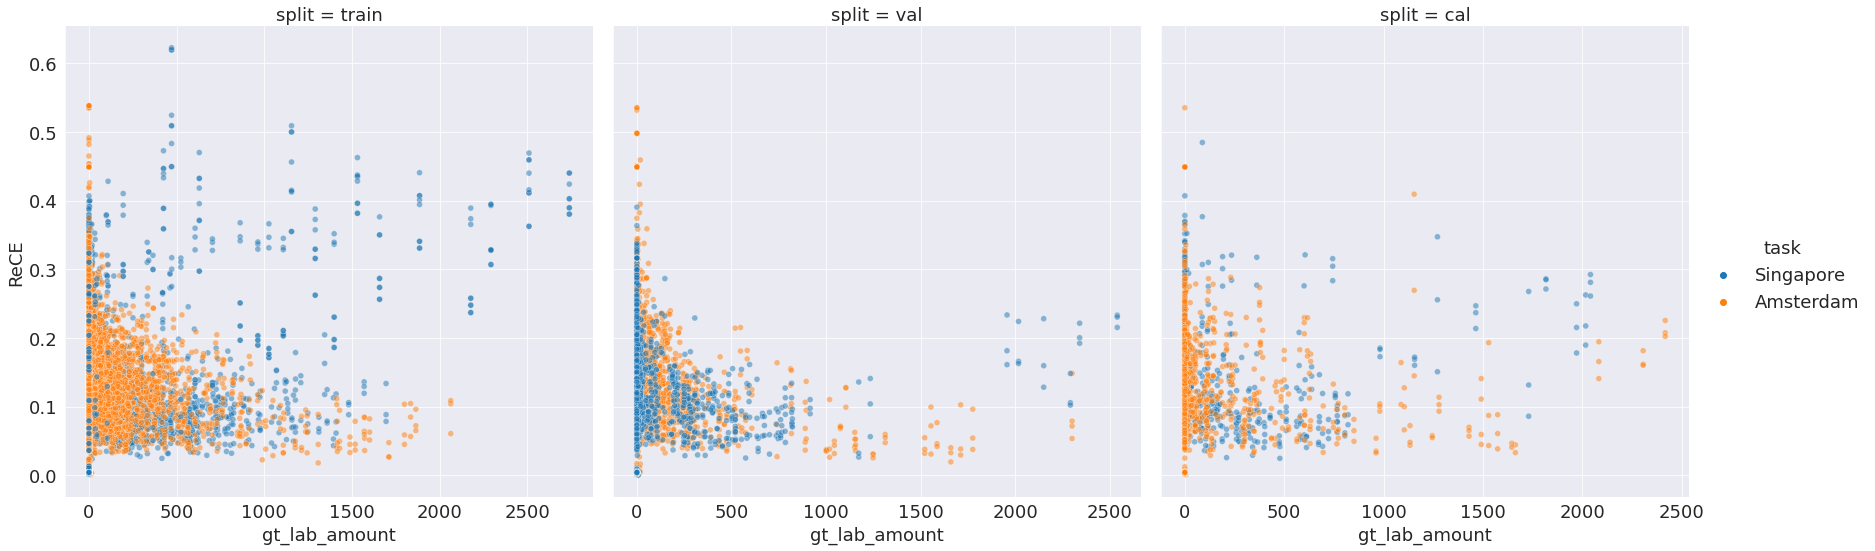

In [16]:
plt.rcParams.update({'font.size': 18})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=all_logs[all_logs['cal_metric'] == metric],
        x='gt_lab_amount',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1)
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

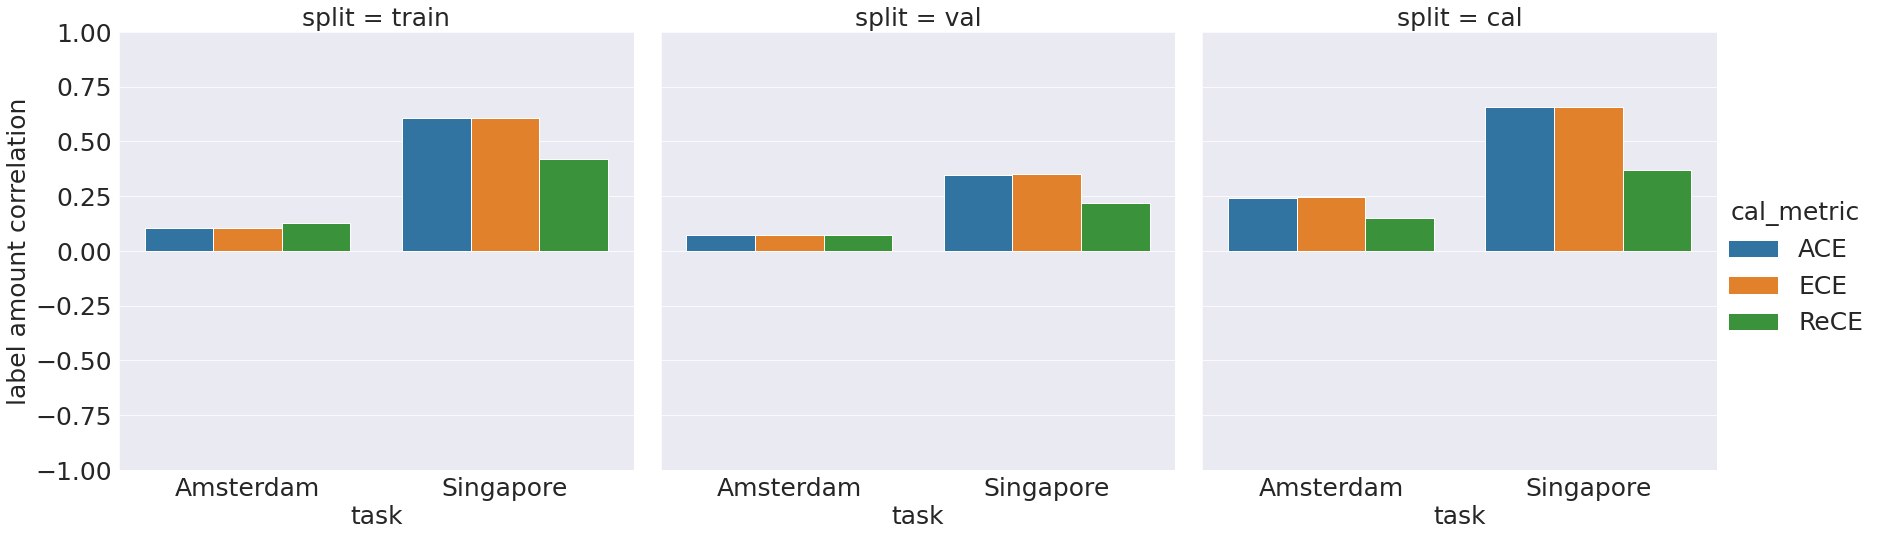

In [17]:
plt.rcParams.update({'font.size': 25})  

# Group by the three columns and apply correlation
label_amount_correlations = grouped_logs.apply(lambda x: x['gt_lab_amount'].corr(x['cal_score'])).reset_index(name='label amount correlation')
label_amount_correlations = reorder_splits(label_amount_correlations)
g = sns.catplot(data=label_amount_correlations, 
                x="task", 
                y="label amount correlation", 
                hue='cal_metric', 
                col="split", 
                kind="bar", 
                height=8, 
                aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

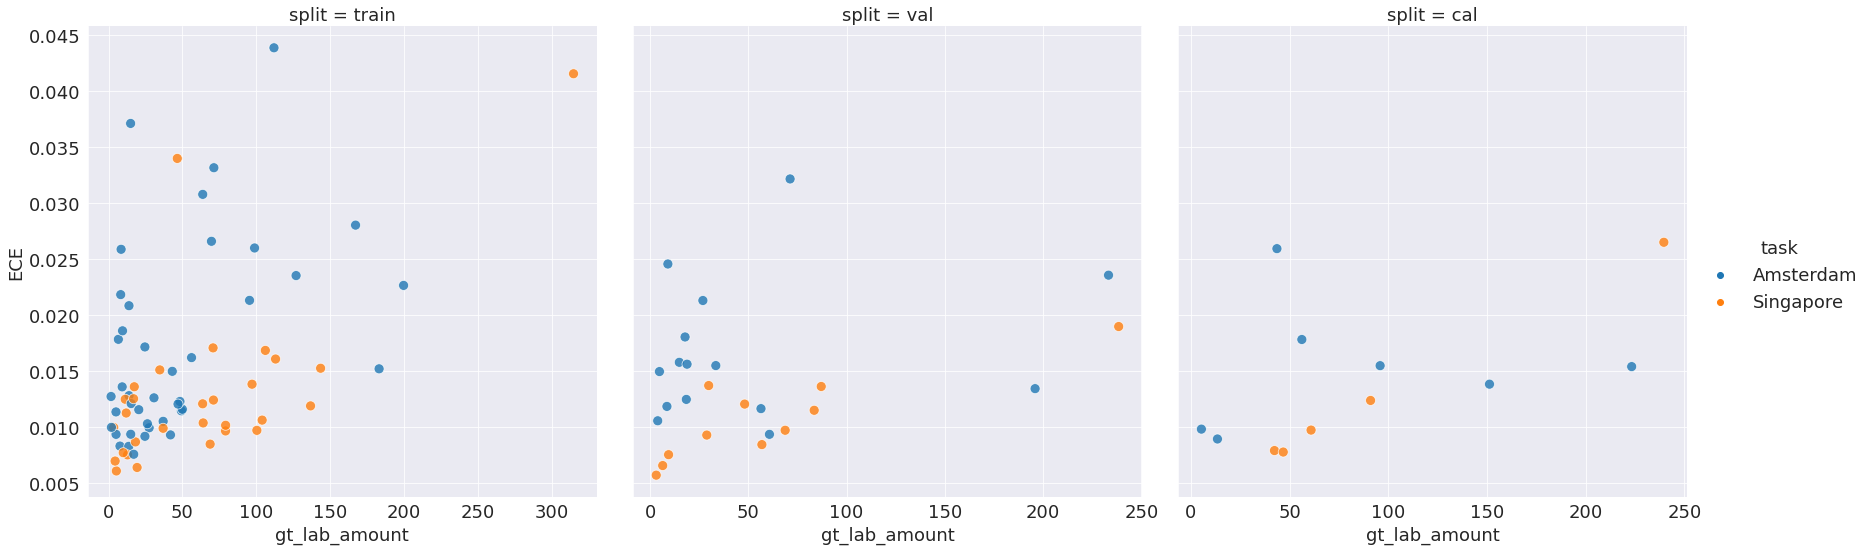

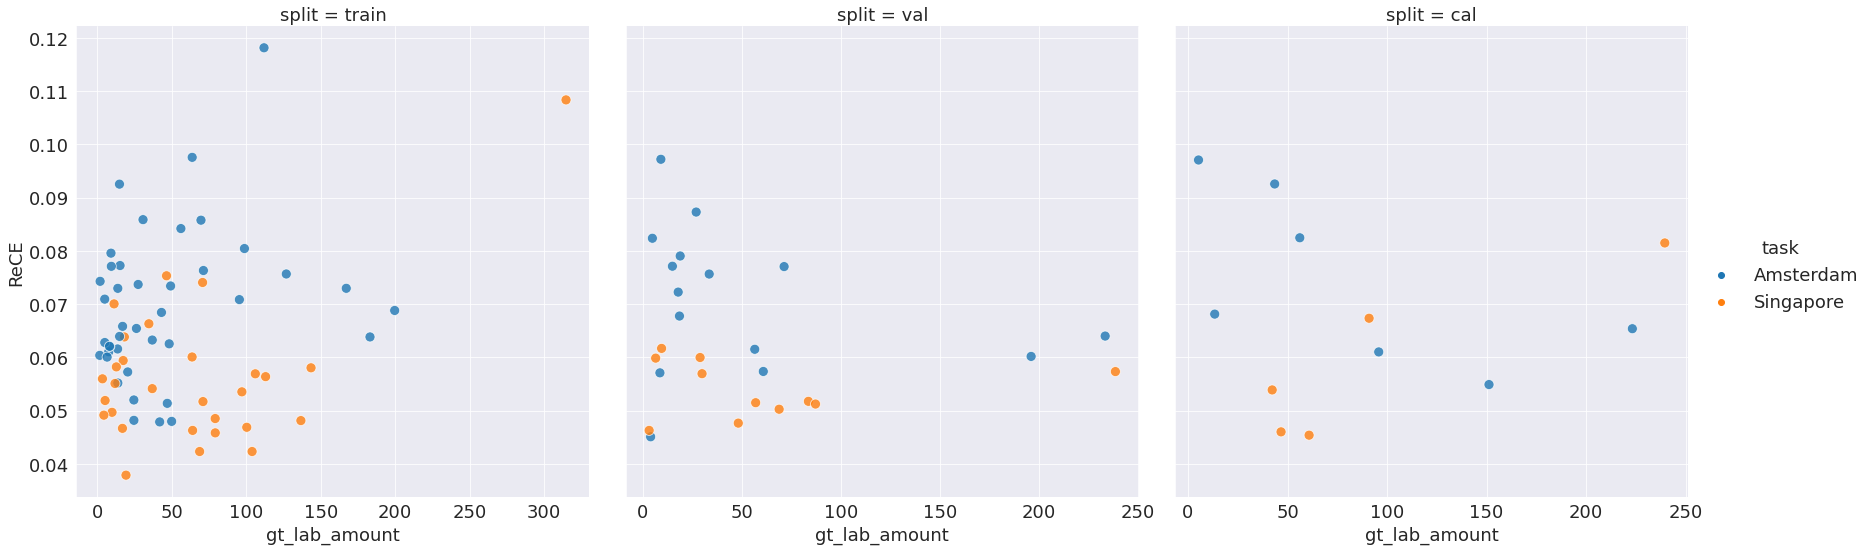

In [18]:
plt.rcParams.update({'font.size': 18})  

for metric in ["ECE", "ReCE"]:
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['cal_metric'] == metric],
        x='gt_lab_amount',
        y='cal_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1)
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

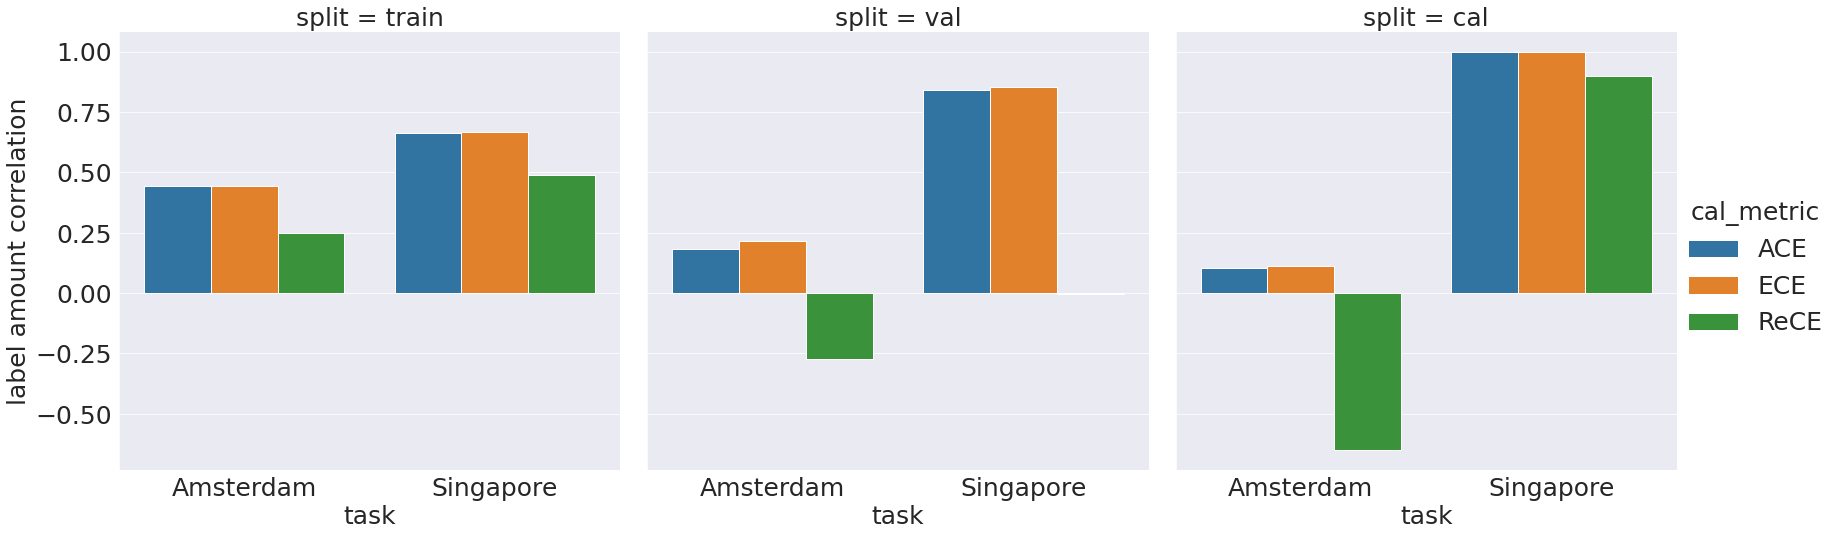

In [19]:

plt.rcParams.update({'font.size': 25})  

# Group by the three columns and apply correlation
label_amount_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['gt_lab_amount'].corr(x['cal_score'])).reset_index(name='label amount correlation')
label_amount_subject_correlations = reorder_splits(label_amount_subject_correlations)
sns.catplot(data=label_amount_subject_correlations, 
            x="task", 
            y="label amount correlation", 
            hue='cal_metric', 
            col="split", 
            kind="bar", 
            height=8, 
            aspect=1)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))